In [2]:
from data_utils import get_prepared_data
import pandas as pd

# df = get_prepared_data()

# df.to_csv('prepared_data.csv', index=False) 
df = pd.read_csv('prepared_data.csv')  

In [3]:
df["gender"] = (df["gender"] == "F")
df = df.drop("participationStartDate", axis=1)
df

,bpm,pcode,bpm-1min,bpm-5min,bpm-10min,temperature,temperature-1min,temperature-5min,temperature-10min,brightness,...,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,64.0,P67,64.0,72.0,73.0,32.020000,32.020000,32.290001,32.799999,0.0,...,21,False,12,9,5,12,9,14,5,7
1,76.0,P62,74.0,82.0,77.0,32.560001,32.330002,32.389999,32.330002,0.0,...,20,False,15,15,9,11,7,24,4,19
2,75.0,P69,42.0,77.0,71.0,29.549999,29.420000,28.809999,29.020000,6.0,...,18,False,3,6,10,9,7,22,4,16
3,78.0,P70,78.0,78.0,83.0,34.099998,34.020000,33.939999,33.980000,21.0,...,38,False,12,10,8,8,7,14,1,10
4,70.0,P01,74.0,72.0,78.0,30.070000,29.879999,29.200001,31.709999,122.0,...,27,False,11,11,3,4,13,13,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,82.0,P12,77.0,75.0,91.0,33.230000,33.320000,33.950001,33.950001,145.0,...,20,False,9,12,7,7,12,14,6,4
1300,74.0,P76,73.0,78.0,89.0,34.959999,35.020000,35.230000,35.230000,0.0,...,18,False,8,8,12,6,8,21,14,21
1301,75.0,P66,90.0,105.0,93.0,33.200001,33.119999,32.799999,32.630001,0.0,...,18,False,8,10,8,8,10,19,10,13
1302,69.0,P79,80.0,70.0,71.0,30.830000,30.530001,28.990000,28.760000,113.0,...,23,False,9,10,7,12,11,13,2,6


**Split into train and test sets**

In [4]:
from sklearn.model_selection import train_test_split
import random

pcodes = list(set(df["pcode"]))
test_pcodes = set([random.choice(pcodes) for _ in range(int(0.1*len(pcodes)))])

test_pcodes_df = df[df["pcode"].isin(test_pcodes)]
df =  df[~df["pcode"].isin(test_pcodes)]

df = df.drop("pcode", axis=1)
test_pcodes_df = test_pcodes_df.drop("pcode", axis=1)

y_columns = ['valence', 'arousal', 'attention', 'stress']
X = df.drop(y_columns, axis=1)
y = df[y_columns]

X_test_pcodes = test_pcodes_df.drop(y_columns, axis=1)
y_test_pcodes = test_pcodes_df[y_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

X_test = pd.concat([X_test, X_test_pcodes], ignore_index=True)
y_test = pd.concat([y_test, y_test_pcodes], ignore_index=True)

In [5]:
len(X_test), len(X_train)

(278, 1026)

**Logistic Regression**

In [6]:
import numpy as np
from mord import LogisticIT  # LogisticIT is for immediate-threshold ordinal regression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from model_utils import get_metrics, plot_model_comparison

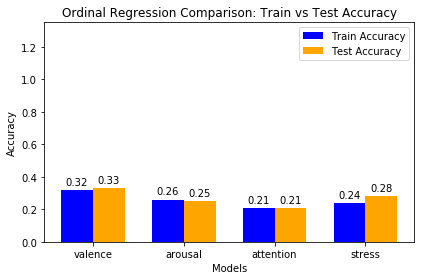

In [ ]:
ordinal_train_acc = []
ordinal_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    ordinal_model = LogisticIT()
    ordinal_model.fit(X_train, y_train[target])

    test_preds = ordinal_model.predict(X_test)
    train_preds = ordinal_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    ordinal_train_acc.append(train_accuracy)
    ordinal_test_acc.append(test_accuracy)

plot_model_comparison("Ordinal Regression", y_columns, ordinal_test_acc, ordinal_train_acc)


**AdaBoost Classifier**

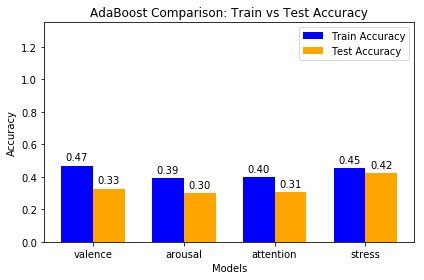

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_train_acc = []
ada_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    ada_args = {"n_estimators": 300, "learning_rate": 0.5}
    ada_model = AdaBoostClassifier(**ada_args)
    ada_model.fit(X_train, y_train[target])

    test_preds = ada_model.predict(X_test)
    train_preds = ada_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    ada_train_acc.append(train_accuracy)
    ada_test_acc.append(test_accuracy)

plot_model_comparison("AdaBoost", y_columns, ada_test_acc, ada_train_acc)


**GradientBoost Classifier**

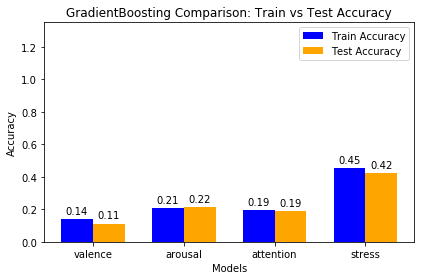

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_train_acc = []
gb_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    gb_args = {"n_estimators": 300}
    gb_model = GradientBoostingClassifier(**gb_args)
    gb_model.fit(X_train, y_train[target])

    test_preds = ada_model.predict(X_test)
    train_preds = ada_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    gb_train_acc.append(train_accuracy)
    gb_test_acc.append(test_accuracy)

plot_model_comparison("GradientBoosting", y_columns, gb_test_acc, gb_train_acc)


**Naive Bayes Classifier**

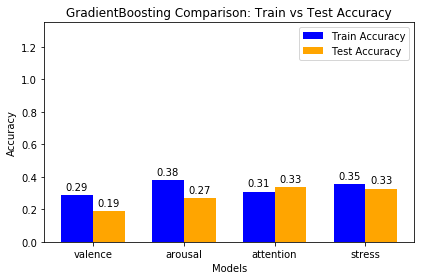

In [58]:
from sklearn.naive_bayes import GaussianNB

nb_train_acc = []
nb_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    nb_args = {}
    nb_model = GaussianNB(**nb_args)
    nb_model.fit(X_train, y_train[target])

    test_preds = nb_model.predict(X_test)
    train_preds = nb_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    nb_train_acc.append(train_accuracy)
    nb_test_acc.append(test_accuracy)

plot_model_comparison("GradientBoosting", y_columns, nb_test_acc, nb_train_acc)


**Random Forest Classifier**

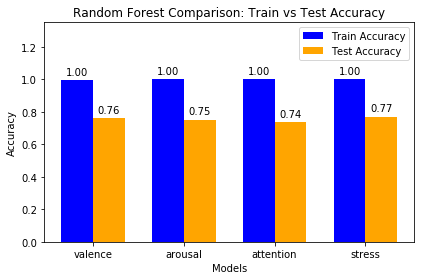

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf_train_acc = []
rf_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    rf_args = {"n_estimators": 250}
    rf_model = RandomForestClassifier(**rf_args)
    rf_model.fit(X_train, y_train[target])

    test_preds = rf_model.predict(X_test)
    train_preds = rf_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    rf_train_acc.append(train_accuracy)
    rf_test_acc.append(test_accuracy)

plot_model_comparison("Random Forest", y_columns, rf_test_acc, rf_train_acc)


**Stacking Classifier**

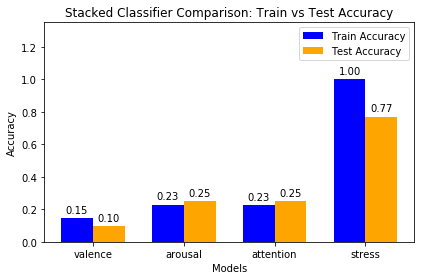

In [59]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

stacking_train_acc = []
stacking_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    estimators = [
        ("rf", RandomForestClassifier(**rf_args)),
        ("nb", GaussianNB(**nb_args)),
        ("gb", GradientBoostingClassifier(**gb_args)),
        ("ada", AdaBoostClassifier(**ada_args)),        
    ]    
    stacking_model = StackingClassifier(
        estimators=estimators, final_estimator=LogisticRegression()
    )
    stacking_model.fit(X_train, y_train[target])

    test_preds = rf_model.predict(X_test)
    train_preds = rf_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    stacking_train_acc.append(train_accuracy)
    stacking_test_acc.append(test_accuracy)

plot_model_comparison("Stacked Classifier", y_columns, stacking_test_acc, stacking_train_acc)


**Neural Net**

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

inputs = layers.Input(shape=X_train.shape[1])

m = layers.Dense(256, activation='relu')(inputs)
m = layers.Dropout(0.2)(m)
m = layers.Dense(128, activation='relu')(m)
m = layers.Dropout(0.2)(m)
m = layers.Dense(64, activation='relu')(m)
m = layers.Dropout(0.2)(m)
m = layers.Dense(16, activation='relu')(m)

valence_output = layers.Dense(7, activation='softmax', name='valence')(m)
arousal_output = layers.Dense(7, activation='softmax', name='arousal')(m)
attention_output = layers.Dense(7, activation='softmax', name='attention')(m)
stress_output = layers.Dense(7, activation='softmax', name='stress')(m)

model = models.Model(inputs=inputs, outputs=[valence_output, arousal_output, attention_output, stress_output])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],

)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          6912        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dropout[0]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Add 3 to convert to 0 to 6 instead of -3 to 3
y_train_valence = y_train['valence'].values + 3
y_train_arousal = y_train['arousal'].values + 3
y_train_attention = y_train['attention'].values + 3
y_train_stress = y_train['stress'].values + 3

y_test_valence = y_test['valence'].values + 3
y_test_arousal = y_test['arousal'].values + 3
y_test_attention = y_test['attention'].values + 3
y_test_stress = y_test['stress'].values + 3


In [15]:
from model_utils import plot_training_history

history = model.fit(
    X_train_scaled,
    {
        'valence': y_train_valence,
        'arousal': y_train_arousal,
        'attention': y_train_attention,
        'stress': y_train_stress
    },
    epochs=200,
    batch_size=64,
    validation_split=0.2
)

Train on 820 samples, validate on 206 samples
Epoch 1/200
820/820 [==============================] - 1s 1ms/sample - loss: 7.7482 - valence_loss: 1.8857 - arousal_loss: 1.9494 - attention_loss: 1.9320 - stress_loss: 1.9800 - valence_acc: 0.2829 - arousal_acc: 0.1756 - attention_acc: 0.1768 - stress_acc: 0.1134 - val_loss: 7.5901 - val_valence_loss: 1.8590 - val_arousal_loss: 1.8848 - val_attention_loss: 1.9111 - val_stress_loss: 1.9116 - val_valence_acc: 0.3981 - val_arousal_acc: 0.1990 - val_attention_acc: 0.2087 - val_stress_acc: 0.1699
Epoch 2/200
820/820 [==============================] - 0s 250us/sample - loss: 7.5224 - valence_loss: 1.8031 - arousal_loss: 1.8771 - attention_loss: 1.9013 - stress_loss: 1.9400 - valence_acc: 0.3244 - arousal_acc: 0.1890 - attention_acc: 0.2220 - stress_acc: 0.1183 - val_loss: 7.3792 - val_valence_loss: 1.7797 - val_arousal_loss: 1.8540 - val_attention_loss: 1.8852 - val_stress_loss: 1.9362 - val_valence_acc: 0.3252 - val_arousal_acc: 0.1990 - val_a

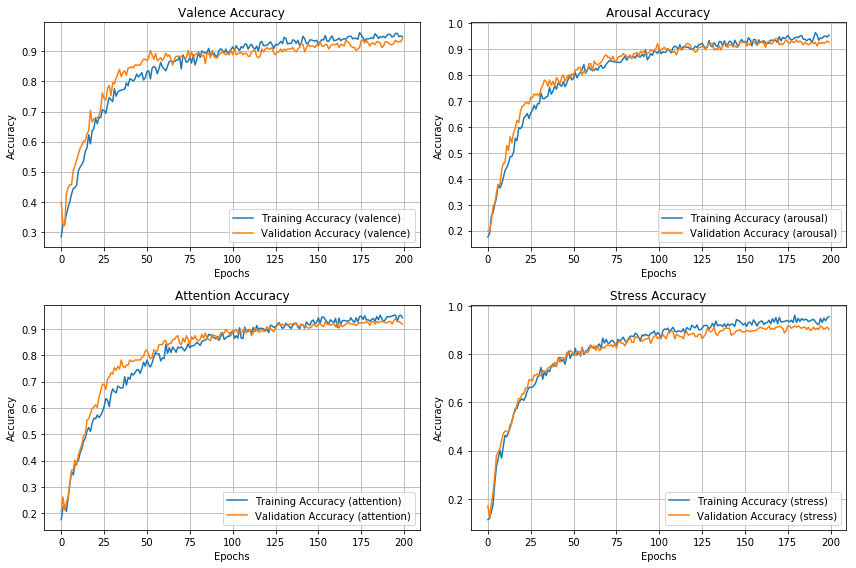

In [16]:
plot_training_history(history=history)

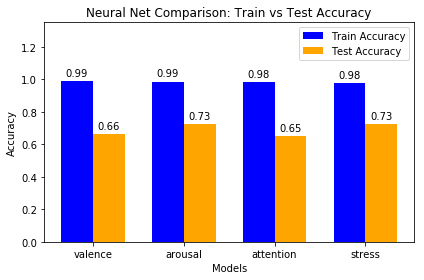

In [17]:
nn_train_acc = []
nn_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    model.predict(X_test_scaled)

    # Subtract 3 to convert back to 0 to 6
    test_preds = np.argmax(model.predict(X_test_scaled)[i], axis=1) - 3
    train_preds = np.argmax(model.predict(X_train_scaled)[i], axis=1) - 3

    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    nn_train_acc.append(train_accuracy)
    nn_test_acc.append(test_accuracy)

plot_model_comparison("Neural Net", y_columns, nn_test_acc, nn_train_acc)
